In [1]:
%config IPCompleter.greedy=True

In [2]:
from requests import get
from bs4 import BeautifulSoup
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

In [3]:
url = 'https://www.minsal.cl/nuevo-coronavirus-2019-ncov/casos-confirmados-en-chile-covid-19/'
response = get(url)

In [4]:
html_soup = BeautifulSoup(response.text, 'html.parser')

In [5]:
#Almaceno los links de los archivos PDF
links = []
for table in html_soup.find_all('table'):
    for a in table.find_all('a'):
        links.append(a['href'])
    break

links

['https://www.minsal.cl/wp-content/uploads/2020/03/2020-03-17-Casos-confirmados.pdf',
 'https://www.minsal.cl/wp-content/uploads/2020/03/2020-03-16-Casos-Confirmados.pdf',
 'https://www.minsal.cl/wp-content/uploads/2020/03/2020-03-15-Casos-confirmados.pdf',
 'https://www.minsal.cl/wp-content/uploads/2020/03/2020-03-14-Casos-confirmados.pdf',
 'https://www.minsal.cl/wp-content/uploads/2020/03/2020-03-13-Casos-Confirmados-Covid-19.pdf']

In [6]:
#import tabula
import camelot

#Se extrae el pdf desde los links
df1 = camelot.read_pdf(links[0], pages='1-end', line_scale=40)
#df1 = tabula.read_pdf(links[0], pages='all', multiple_tables = True)
#tabula.convert_into(links[0], "datos.csv", all = True)
df1[0].df.tail(50)

,0,1,2,3,4
158,,,Masculino,28,Clinica Alemana
159,,,Femenino,34,Clinica Alemana
160,,,Masculino,73,Clinica Alemana
161,O’Higgins,—,—,—,—
162,Maule,9,Masculino,33,Hospital de Talca
163,,,Femenino,33,
164,,,Masculino,39,
165,,,Femenino,2,
166,,,Masculino,21,
167,,,Femenino,24,


In [7]:
df = df1[0].df
len(df.index)

208

In [8]:
#Seteo columnas del DataFrame, se elimina la primera y última fila, por último se elimina la columna 'Casos confirmados'
df.columns = df.iloc[1].values
df = df.drop([0,1,len(df.index)-1]).reset_index(drop=True)
df = df.drop(['Casos confirmados'], axis=1)
df=df.rename(columns = {'Centro de salud':'Centro_salud'})
df.columns

Index(['Región', 'Sexo', 'Edad', 'Centro_salud'], dtype='object')

In [9]:
#Se normaliza la columna sexo y Centro_salud, por último se reemplazan por valores que lo preceden
df['Sexo'] = df['Sexo'].str.replace('Fememino','Femenino')
df['Centro_salud'] = df['Centro_salud'].str.replace('\n',' ')
df['Región'] = df['Región'].str.replace('\n','')
df['Región'] = df['Región'].str.replace('Metropolitan a','Metropolitana')
df = df.replace('',np.nan)
df = df.fillna(method='ffill')

In [10]:
#Se eliminan filas que no tengan sexo
df = df[df["Sexo"]!='—'].reset_index(drop=True)

In [11]:
#Se transforma el formato de la columna Edad, de String a Entero
#df['Edad'] = df['Edad'].astype(str).astype(int)

In [12]:
#Tabla final con todos los datos de contagios
df

,Región,Sexo,Edad,Centro_salud
0,Antofagasta,Femenino,58,Hospital Carlos Cisternas Calama
1,Antofagasta,Masculino,63,Hospital Carlos Cisternas Calama
2,Atacama,Masculino,50,Hospital de Copiapó
3,Valparaíso,Masculino,34,Clínica Ciudad del Mar
4,Metropolitana,Femenino,54,Clínica Alemana
...,...,...,...,...
196,Los Ríos,Femenino,1,Clinica Alemana Valdivia
197,Los Lagos,Femenino,20,Hospital de Puerto Montt
198,Aysén,Masculino,83,Hospital de Aysén
199,Magallanes,Masculino,70,Clínica Magallanes


In [13]:
from datetime import datetime

#Exportamos los datos del día a CSV
df.to_csv(str(datetime.today().strftime('%d-%m-%Y')) + '.csv')

In [24]:
df1 = df.groupby('Región', sort=False)['Región'].count().reset_index(name='Cantidad')

In [25]:
df1

,Región,Cantidad
0,Antofagasta,2
1,Atacama,1
2,Valparaíso,1
3,Metropolitana,152
4,Maule,9
5,Ñuble,26
6,Biobío,4
7,Araucanía,1
8,Los Ríos,1
9,Los Lagos,1


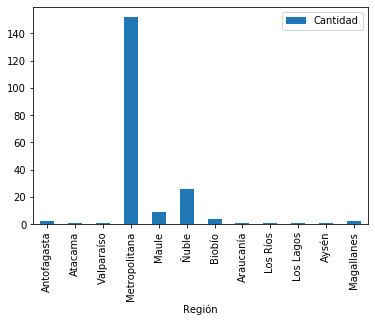

In [26]:
df1.plot(kind='bar',x='Región',y='Cantidad')

In [27]:
#df.hist(bins=6)

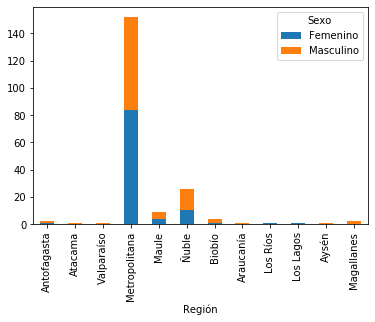

In [33]:
df.groupby(['Región','Sexo'], sort=False).size().unstack().plot(kind='bar',stacked=True)
plt.show()

In [35]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

geolocator = Nominatim(user_agent="Covid19-CL")
location = geolocator.geocode("Clínica Las Condes, Región Metropolitana, Chile")
print(location.address)
#Flatiron Building, 175, 5th Avenue, Flatiron, New York, NYC, New York, ...
print((location.latitude, location.longitude))
#(40.7410861, -73.9896297241625)
#print(location.raw)
#{'place_id': '9167009604', 'type': 'attraction', ...}

Clinica Las Condes, 450, Estoril, Las Condes, Provincia de Santiago, Región Metropolitana de Santiago, 7550000, Chile
(-33.3840374, -70.5309885140944)


In [36]:
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=2)
df2 = df1.drop(['Cantidad'], axis=1)
lat = []
lon = []
for index, row in df2.iterrows():
    location = geocode('Región ' + row['Región'] + ', Chile')
    lat.append(location.latitude)
    lon.append(location.longitude)
df2['lat'] = lat
df2['lon'] = lon


In [37]:
dfm = pd.merge(df, df2, on='Región')
dfm

,Región,Sexo,Edad,Centro_salud,lat,lon
0,Antofagasta,Femenino,58,Hospital Carlos Cisternas Calama,-22.455864,-68.927458
1,Antofagasta,Masculino,63,Hospital Carlos Cisternas Calama,-22.455864,-68.927458
2,Atacama,Masculino,50,Hospital de Copiapó,-26.385295,-70.047757
3,Valparaíso,Masculino,34,Clínica Ciudad del Mar,-32.786024,-71.203457
4,Metropolitana,Femenino,54,Clínica Alemana,-33.435442,-70.676616
...,...,...,...,...,...,...
196,Los Ríos,Femenino,1,Clinica Alemana Valdivia,-39.819592,-73.243910
197,Los Lagos,Femenino,20,Hospital de Puerto Montt,-42.898024,-72.438891
198,Aysén,Masculino,83,Hospital de Aysén,-46.459024,-72.671786
199,Magallanes,Masculino,70,Clínica Magallanes,-53.352752,-71.554778


In [38]:
import folium
from folium.plugins import MarkerCluster

map1 = folium.Map(
    location=[-35.675148,-71.5429688],
    tiles='cartodbdark_matter',
    zoom_start=4.5,
)
mc = MarkerCluster()

for row in dfm.itertuples():
    mc.add_child(folium.Marker(location=[row.lat, row.lon], popup=folium.Popup('Edad: ' + row.Edad + ' ' + row.Sexo + '  (' + row.Centro_salud + ')', max_width=90), icon=folium.Icon(color='red')))
mc.add_to(map1)
map1
#folium.CircleMarker(location= [location.latitude, location.longitude]).add_to(map1)
#df.apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]]).add_to(map1), axis=1)
#df_loc.apply(lambda row:folium.Marker(location=[row['lat'], row['lon']], popup = row['Edad']).add_to(map1), axis=1)
#map1

In [39]:
#El mapa se exporta a HTML
map1.save('home.html')